## **Notebook EC#01**
## Regularized Linear Classifier for the MNIST database.
## Part 1: Designed from scratch.
## Part 2: High-level commands.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Túlio Queiroz de Paula


#**Let us start with Part 1: Designed from scratch.**

In [107]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from keras.datasets import mnist

(Xp, y), (Xtp, yt) = mnist.load_data()
Xa = Xp.reshape(Xp.shape[0], 784)
Xta = Xtp.reshape(Xtp.shape[0], 784)

Xa = Xa / 255.0
Xta = Xta / 255.0

X0 = np.ones((Xp.shape[0],1))
X = np.hstack((X0,Xa))
Xt0 = np.ones((Xtp.shape[0],1))
Xt = np.hstack((Xt0,Xta))

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

Shape of X:  (60000, 785)
Shape of y:  (60000,)
Shape of Xt:  (10000, 785)
Shape of yt:  (10000,)


In [108]:
# Visualizing a random data point. It expected that you execute this cell several times.
import plotly.express as px

ind = np.random.randint(60000)
print('Data point: ', ind, '\nLabel: ', y[ind])
fig = px.imshow(255-Xp[ind], binary_string=True, width=200, height=200)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(margin=dict(l=1, r=1, t=1, b=1))
fig.show()

Data point:  24925 
Label:  8


In [3]:
# Dataset balancing analysis
from tensorflow.keras.utils import to_categorical

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)
fig1 = px.bar(x=range(10),y=sum_along_columns1, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the training dataset</b>")
fig1.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig1.show()
fig2 = px.bar(x=range(10),y=sum_along_columns2, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the test dataset</b>")
fig2.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig2.show()

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [4]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

X_training:          (42000, 785)
y_training:          (42000, 10)
X_validation:        (18000, 785)
y_validation:        (18000, 10)


In [5]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_

In [6]:
def get_w(X, y, c):
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w


In [7]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []

    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)

        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [8]:
c_values = [pow(2,d) for d in range(-10, 19, 2)] # Range goes up to 19 to ensure search up to 2^18

hit_rates_training, Ws = get_rates_from_c_values(X_training, y_training, c_values)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144


In [9]:
hit_rates_validation, _ = get_rates_from_c_values(X_validation, y_validation, c_values, Ws)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144


Best c value: 1024 
Performance of this value: 0.8526666666666667


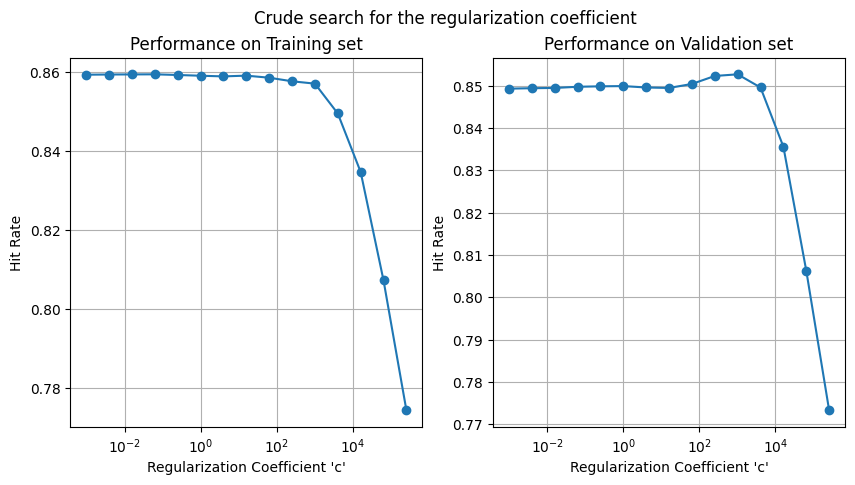

In [10]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))



<font color="green">
Atividade (a) <br>
Confira se o intervalo de excursão da busca está adequado. Justifique sua resposta. <br>
Caso não esteja, faça modificações pertinentes até encontrar um bom intervalo de busca. <br>
</font>

Resposta: <br><br>
Sim, pois o melhor valor ("Best c value") obtido é para c = 1024 (2<sup>10</sup>) e a excursão investiga valores no intervalo [2<sup>-10</sup>, 2<sup>18</sup>] no código original. Não é necessário aumentar esse range, pois o valor é um ponto de máximo. Nota-se pelo gráfico que os valores de Hit-Rate são menores à esquerda e muito menores (queda drátisca) para valores à direita.

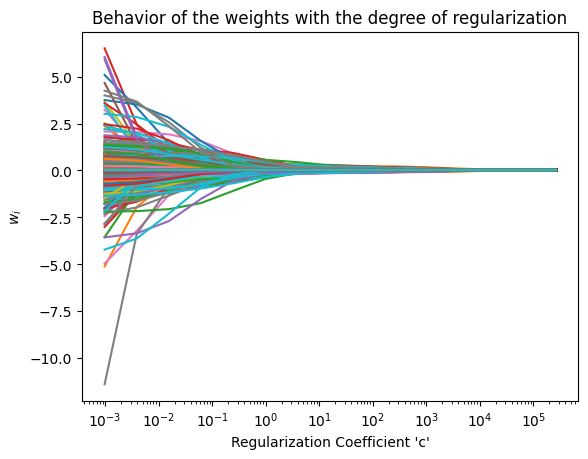

In [11]:
lambd_values = c_values
w_values = Ws

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel("Regularization Coefficient 'c'", fontsize=10)
    plt.ylabel("$w_{i}$", fontsize=10)
    plt.xscale("log")
    plt.title("Behavior of the weights with the degree of regularization")
    plt.show()

plot_regularization_path(lambd_values, w_values)

In [12]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(X_training, y_training, fine_c_values)

256.0
640.0
1024.0
1408.0
1792.0
2176.0
2560.0
2944.0
3328.0
3712.0
4096.0


In [13]:
hit_rates_validation_fine, _ = get_rates_from_c_values(X_validation, y_validation, fine_c_values, Ws_fine)

256.0
640.0
1024.0
1408.0
1792.0
2176.0
2560.0
2944.0
3328.0
3712.0
4096.0


Best c value: 1408.0 
Performance of this value: 0.8536111111111111


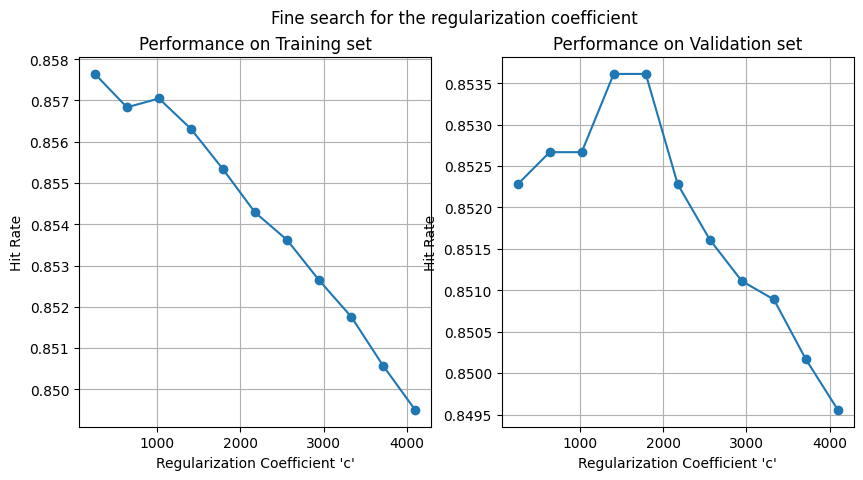

In [14]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [15]:
W = get_w(X, yy, best_c)
print(W.shape)

(785, 10)


In [16]:
yt_estimate = np.matmul(Xt,W)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.8634


,0,1,2,3,4,5,6,7,8,9
0,941,0,18,5,1,21,14,5,13,22
1,0,1105,64,17,23,17,10,44,55,14
2,1,2,829,25,6,4,5,17,8,3
3,2,2,20,886,0,89,0,7,31,13
4,1,2,14,3,883,26,17,15,24,65
5,8,1,0,11,2,624,16,0,26,2
6,18,5,22,10,10,24,890,2,20,1
7,1,1,26,25,1,21,0,895,16,63
8,7,17,34,18,10,45,6,0,761,6
9,1,0,5,10,46,21,0,43,20,820


In [17]:
def f_score(confusion_matrix, betas):
    recall = confusion_matrix[range(10), range(10)]/np.sum(confusion_matrix, axis=0)
    precision = confusion_matrix[range(10), range(10)]/np.sum(confusion_matrix, axis=1)

    f_scores = np.zeros((len(betas), 10))

    for i, b in enumerate(betas):
        f_scores[i] = (1 + b**2) * precision * recall/(b**2 * precision + recall)

    return f_scores

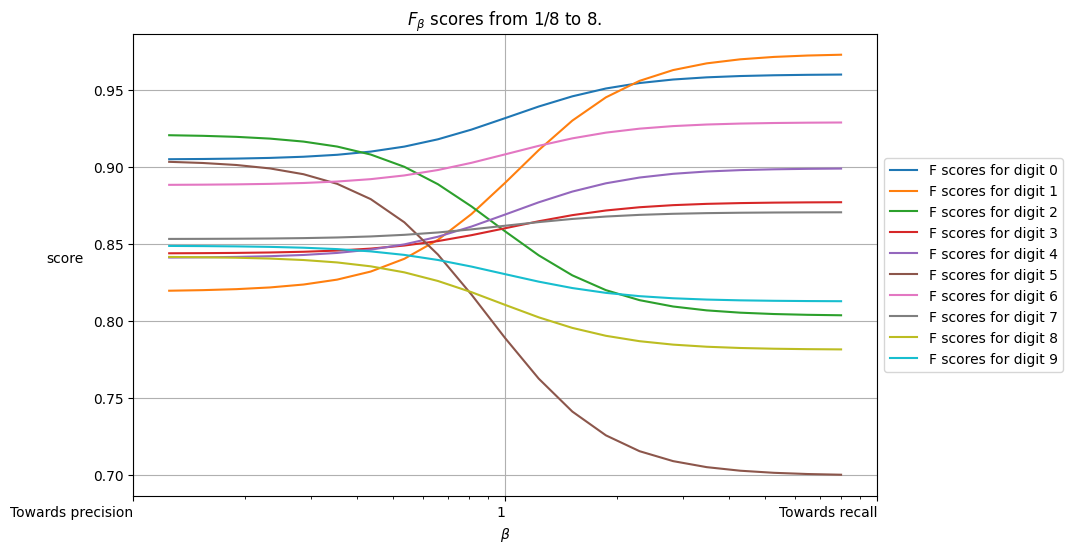

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

for i in range(10):
    plt.plot(np.logspace(-3, 3, base=2, num=21), f_score(confusion_matrix, np.logspace(-4, 4, base=2, num=21))[:, i], label=f"F scores for digit {i}")

ax.set_xlabel("$\\beta$")
ax.set_ylabel("score", rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xticks(np.geomspace(10**-1, 10**1 ,3), ["Towards precision", "1","Towards recall"], ha='right')
ax.grid()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.get_xaxis

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title("$F_{\\beta}$ scores from 1/8 to 8.")

plt.show()

<font color="green">
Atividade (b) <br>
Indique quais são as duas classes mais desafiadoras para o classificador e qual o critério usado por você para chegar a esta conclusão. <br>
</font>

Resposta:

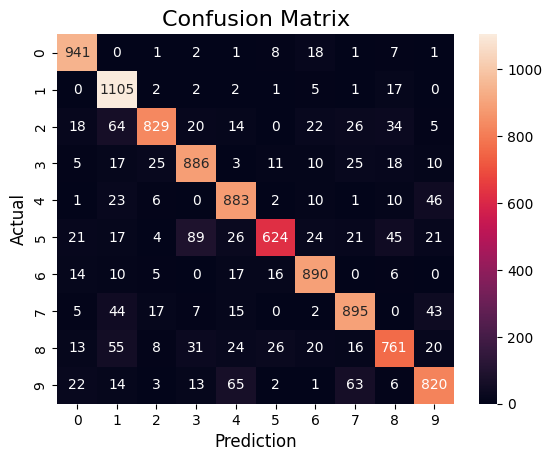

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(yyt.argmax(axis=1), yt_estimate.argmax(axis=1)) # mt.confusion_matrix, de fato, não aceita um vetor de one-hot-encoding...
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

As duas classes mais desafiadoras correspondem ao número "5" e ao número "8". O critério objetivo é analisar a matriz de confusão que indica claramente que são as classes com menor número de acertos - o número "5" é o pior, está em vermelho, seguido do número "8", em laranja escuro.<br>
Ademais, pode-se propor critérios subjetivos, como:
- O classificador confundiu muitas vezes o número "5" pelo número "3" (basta cruzar a 6º linha com a 4ª coluna), possivelmente pelo fato de compartilharem muitos pixels em comum, como uma "linha" de pixels preenchida na parte superior e um idêntico segmento curvado na parte inferior da caligrafia dos números. Vale ressaltar, também, o número significativo de vezes que o "5" foi classificado como "8" (acredito que pelos mesmos motivos de muitos pixels em comum).
- O número 8 tem um número razoável de classificações equivocadas para praticamente todas as demais classes. Pode-se argumentar que o número "8" é o dígito que possui a caligrafia "mais extensa"*, requerindo uma maior quantidade de pixels em diferentes posições, fazendo com que o classificador possa enxergar, dependendo da situação, quase qualquer número ao invés do "8". 

<br><br>
<i>*obs: Basta pensar em um relógio digital, no qual os números são representados com 7 segmentos (2 quadrados unidos por um mesmo segmento). O número 8 requer que todos os 7 segmentos estejam iluminados.


#### **Visualization of the 10 vectors of weights W, without the bias.**



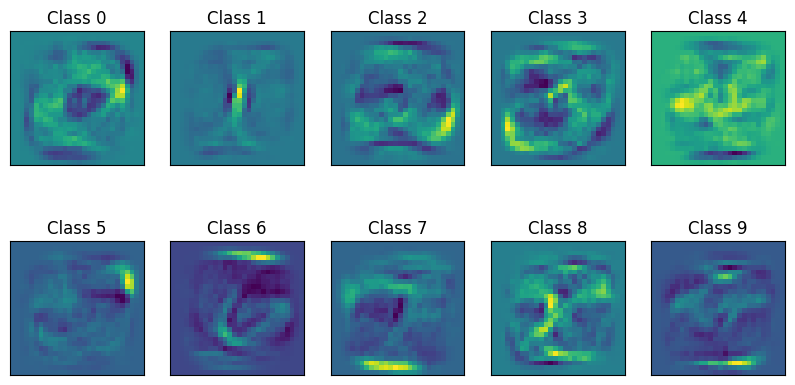

In [20]:
# Only for the MNIST dataset
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W[1:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap='viridis')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

#### **To improve the visualization of the 10 vectors of weights W, the use of a divergent color map is indicated: the average value of the color map is a neutral color and the extreme values represent different colors. Using a divergent color map and a bilinear interpolation scheme (to facilitate the visualization of low-resolution images), the result of the visualization of the 10 vectors of weights W is illustrated in the following images.**

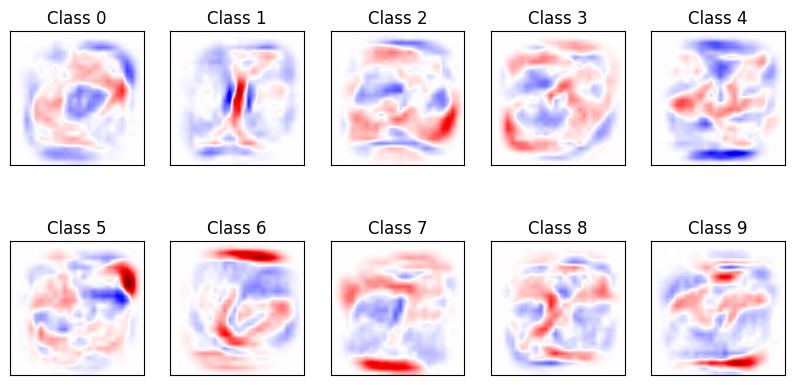

In [21]:
# Only for the MNIST dataset
scale = np.abs(W).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W[1:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

<font color="green">
Atividade (c) <br>
Com base nesses dois resultados visuais acima, responda: Qual é a estratégia adotada pelo classificador linear para buscar máximo desempenho? <br>
</font>

Resposta: <br><br>
Identificar um padrão de maior recorrência dos pixels. <br>O classificador "enxerga" a quantidade de vezes em que um determinado pixel tem sua cor (preto, cinza) diferente do background (branco). Assim, mapeia cada pixel com um valor que reflete quão frequente é esse pixel para cada classe no conjunto de dados. Logo, quando recebe novas imagens para classificar, basta avaliar os pixels das novas imagens, identificar quais posições possuem pixels pretos/cinzas difrentes do background branco e comparar o padrão obtido com o padrão de alguma classe que mais se assemelhe. 

Adendo<br>
Resposta após conversar com o professor:<br>
Identificar os pixels mais frequentes é importante, entretanto, mais importante do que isso, é identificar os pixels mais frequentes que **diferenciam** uma classe da outra. Logo, não necessariamente os pixels serão aqueles que mais representam a caligrafia ideal do número, sendo, portanto, uma mistura de pixels peculiares de uma certa classe, somados aos pixels que tornam essa classe única (pixels que distinguem uma classe da outra). 

</br><i> no practical purpose, just for fun:

In [22]:
def data_vis(array, datapoint, space):
    for data in array[datapoint]:
        st = str()
        for px in data:
            if px == 0:
                px = '000'
            if len(str(px)) == 2:
                px = '0'+ str(px)
            if len(str(px)) == 1:
                px = '00'+str(px)
            
            if space: # without the space (' '): better view but worse idea of pixel value
                st += str(px) + ' ' 
            else:
                st += str(px)
        print(st)

In [23]:
# choose any number between 0 and 59999 and try to visualize the number and its pixels values
# the "drawing" is made of its own pixels (values), hope you see it :)

data_point = 8888 # 8888 = '3'
data_vis(Xp, data_point, space=True) # try: space=False for better view  <--- 
                                     #      space=True for pixel values  <---

000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 026 192 254 254 254 254 254 174 080 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 072 217 253 244 243 243 243 249 253 243 158 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 164 223 121 009 000 000 000 053 130 229 248 120 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 079 127 000 000 000 000 000 000 000 082 253 239 023 000 000 000 000 000 000 

#### **Performance of the average 10 vectors of weights (here no bias is considered)**

In [24]:
W1 = np.zeros((784, 10))
for i in range(10):
    aux = np.mean(Xp[y==i], axis=0)
    aux = aux.reshape(784)/255
    aux = aux-np.mean(aux)
    W1[:,i] = aux/np.sqrt(np.sum(np.square(aux)))
yt_estimate = np.matmul(Xta,W1)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.8208


,0,1,2,3,4,5,6,7,8,9
0,902,0,27,6,4,27,29,8,7,16
1,0,1074,51,5,10,37,14,51,21,17
2,6,9,776,25,3,9,16,26,11,6
3,3,4,43,851,0,137,1,0,91,12
4,0,0,27,1,793,20,18,16,12,80
5,33,4,0,28,1,564,22,0,29,11
6,25,4,31,8,24,29,850,1,17,3
7,1,0,15,14,1,11,0,849,10,29
8,10,40,56,52,19,34,8,22,738,24
9,0,0,6,20,127,24,0,55,38,811


#### **Visualization of the average 10 vectors of weights**

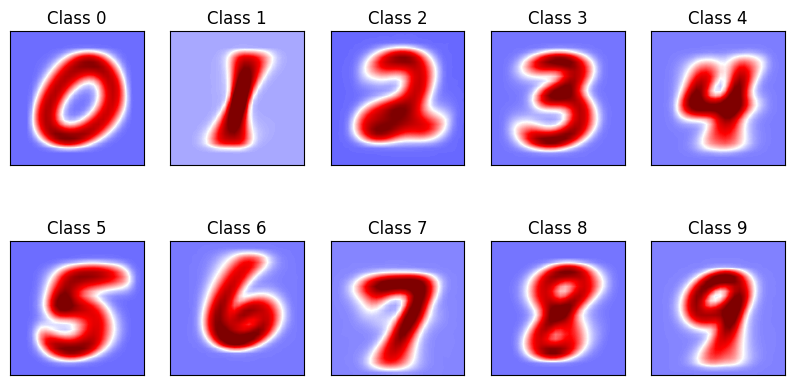

In [25]:
# Only for the MNIST dataset
scale = np.abs(W1).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W1[:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

<font color="green">
Atividade (d) <br>
Com base na execução das duas células acima, responda: Por que motivo os vetores com a média das imagens por classe não levam a um classificador de máximo desempenho? Nota: A resposta não depende do fato do classificador aqui não adotar o bias em sua implementação. <br>
</font>

Resposta: <br> <br>
Menor capacidade de generalização. <br>A média é uma medida que indica uma tendência central de um certo conjunto de dados e uma amostra com uma quantidade significativa de dados terá uma distribuição que normal centrada na média, ou seja, a maioria dos dados estão próximos da média. Nota-se pela representação gráfica das classes (célula acima) que os números estão bem nítidos, claramente indentificáveis, o que é esperado: na maioria das vezes (média) os números estão "bem escritos", uma caligrafia mais usual (uma "caligrafia média") para a maioria das pessoas. Isso implica em uma maior dificuldade do classificador de reconhecer números com uma caligrafia menos usual (mais distantes da média). <br>É uma espécie de overfitting do classificador que muito se adaptou aos dados mais frequentes (maioria dos dados estão próximos à média), tornando-se incapaz de captar dados que, não sendo outliers, divirjam um pouco da tendência central. 

Adendo <br>
Resposta após conversar com Professor: <br>
Mais do que a capacidade de generalização, devemos considerar, como versado na questão anterior, que utilizar as regiões de pixels mais peculiares de cada classe de números nem sempre é a melhor forma de distinguir uma classe da outra. Portanto, regiões que eventualmente não remetam à caligrafia do número, porém são úteis em diferenciar as classes entre si, são significativamente importantes nesse processo de classificação - a queda no desempenho vai ao encontro dessa argumentação.

Image no. 11


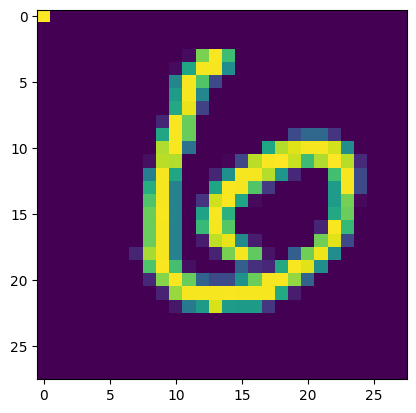

Real: 6
Predicted: 4
Rank of the correct answer: 6
Estimated outputs: [ 0.23368567  0.16012381  0.14317249  0.06792351  0.25748511 -0.16884205
  0.10868754 -0.07912503  0.16923597  0.04993438] 

Image no. 33


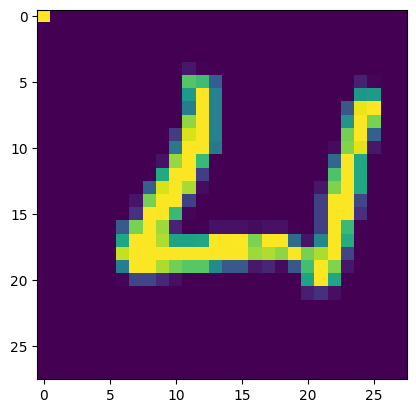

Real: 4
Predicted: 0
Rank of the correct answer: 4
Estimated outputs: [ 0.35910826 -0.08697803  0.18053443 -0.29535708  0.20252526  0.32229653
  0.22680185 -0.05901088  0.07763316 -0.04383708] 

Image no. 38


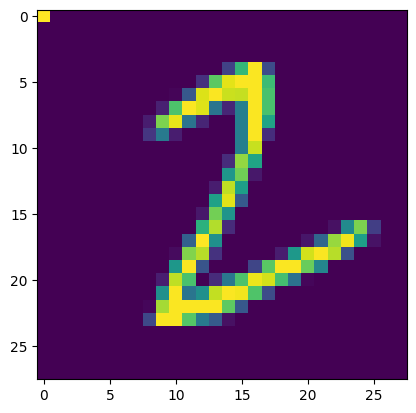

Real: 2
Predicted: 1
Rank of the correct answer: 5
Estimated outputs: [ 0.16930961  0.30744343  0.16427943  0.26178904 -0.28612576  0.08471755
  0.21075283 -0.05482023  0.12987478 -0.09818886] 

Image no. 43


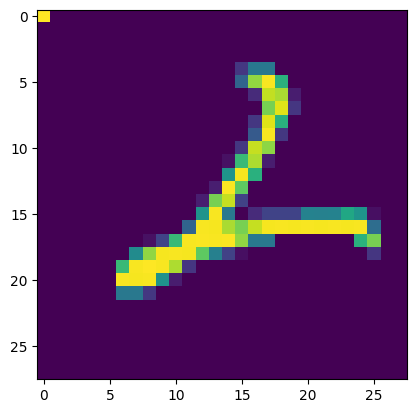

Real: 2
Predicted: 1
Rank of the correct answer: 2
Estimated outputs: [-0.03522563  0.32425342  0.2804795   0.05333207  0.17342958  0.03265424
 -0.00762946 -0.05374386  0.13613465 -0.03392064] 

Image no. 45


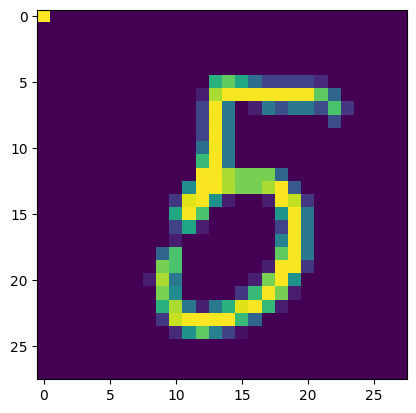

Real: 5
Predicted: 3
Rank of the correct answer: 2
Estimated outputs: [ 0.08505247 -0.12700619 -0.06405478  0.38239697  0.05627937  0.33391288
  0.16718651 -0.10983396  0.18963036 -0.01421716] 

Image no. 46


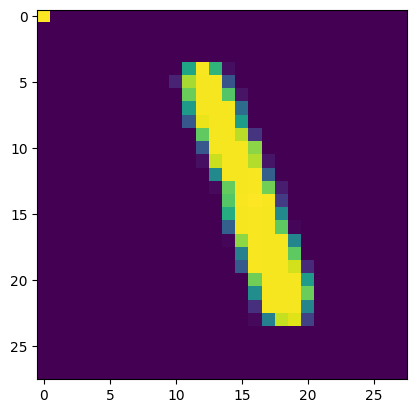

Real: 1
Predicted: 3
Rank of the correct answer: 2
Estimated outputs: [-0.27372684  0.30900034  0.14500066  0.33311321  0.07255791  0.19164193
  0.07141083  0.05653601 -0.00062333  0.0738656 ] 

Image no. 63


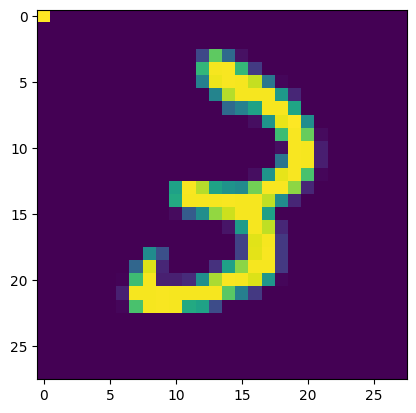

Real: 3
Predicted: 2
Rank of the correct answer: 3
Estimated outputs: [ 0.04536931  0.04472588  0.39545708  0.18907873  0.03438968 -0.00512569
 -0.02346012 -0.11702324  0.10669332  0.27917472] 

Image no. 66


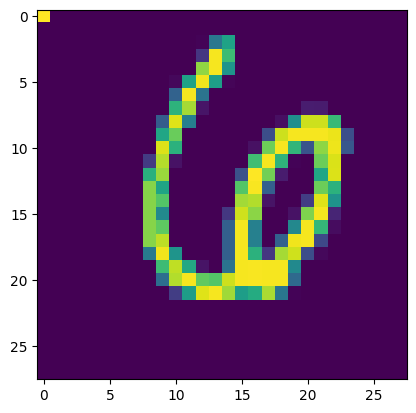

Real: 6
Predicted: 1
Rank of the correct answer: 4
Estimated outputs: [ 0.2113916   0.26618605  0.1264728   0.12221629  0.21391718 -0.09459379
  0.19922129  0.13977497 -0.08289975 -0.14133698] 

Image no. 77


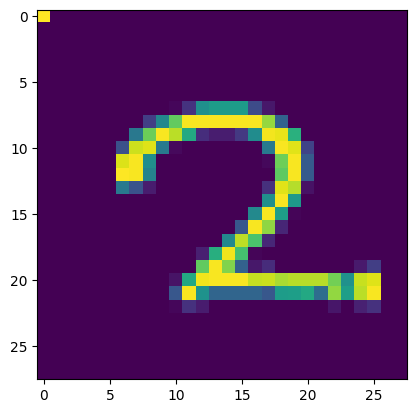

Real: 2
Predicted: 7
Rank of the correct answer: 2
Estimated outputs: [-0.02383481  0.08758779  0.37608616 -0.22787207  0.10868272  0.10704124
  0.07728992  0.42191464 -0.1146534   0.07949935] 

Image no. 80


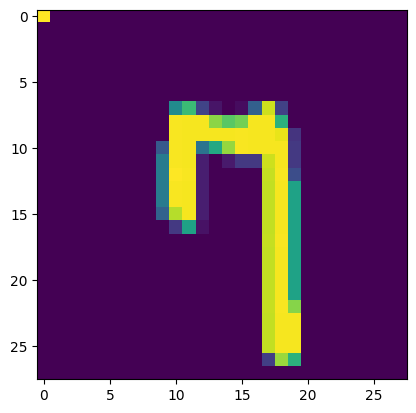

Real: 7
Predicted: 9
Rank of the correct answer: 2
Estimated outputs: [ 0.10708573 -0.13378574 -0.0153081   0.05920912  0.10999975  0.10294602
  0.00384031  0.43985568 -0.19045079  0.49500737] 

Image no. 92


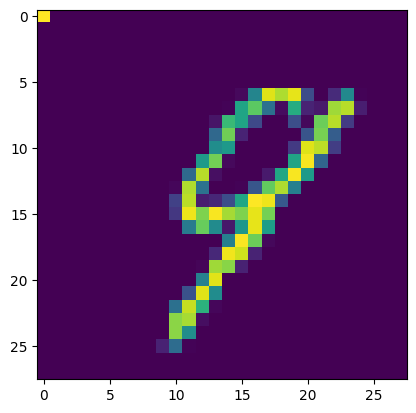

Real: 9
Predicted: 4
Rank of the correct answer: 2
Estimated outputs: [ 0.00874837  0.09284007  0.07468177 -0.0273693   0.2492275   0.0582684
  0.04450216  0.10122422  0.0904994   0.18207763] 

Image no. 97


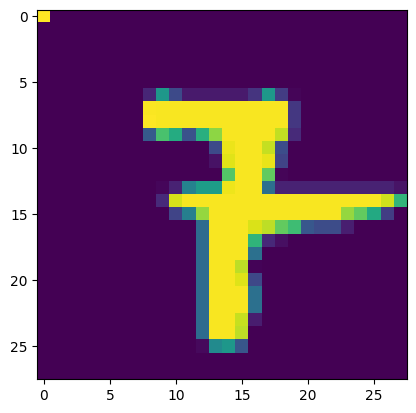

Real: 7
Predicted: 1
Rank of the correct answer: 2
Estimated outputs: [-0.10268155  0.43875795 -0.14954536  0.20173886  0.14116957  0.00376513
  0.2250333   0.35816243 -0.01579355  0.00565503] 

Image no. 111


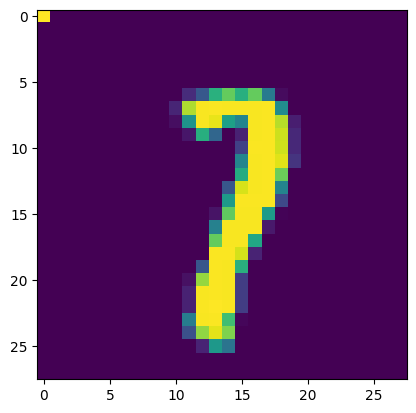

Real: 7
Predicted: 1
Rank of the correct answer: 2
Estimated outputs: [-0.05898499  0.51193897  0.08164115  0.1562989  -0.0910061  -0.01538421
 -0.03010538  0.22679338  0.03072316  0.18566657] 

Image no. 124


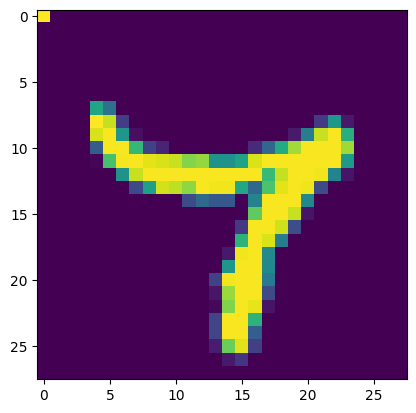

Real: 7
Predicted: 4
Rank of the correct answer: 2
Estimated outputs: [-0.22091089  0.00648917 -0.24085665  0.16626662  0.37762863 -0.06445028
  0.07295114  0.3391078   0.27065637  0.27600692] 

Image no. 149


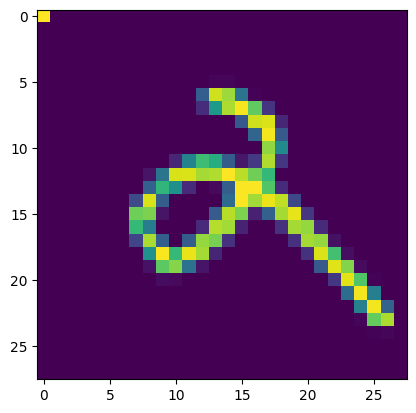

Real: 2
Predicted: 9
Rank of the correct answer: 5
Estimated outputs: [-0.016683    0.25548057  0.09140845  0.05181372  0.19777717  0.05081148
  0.03928934 -0.14840642  0.0917889   0.26026671] 

Image no. 167


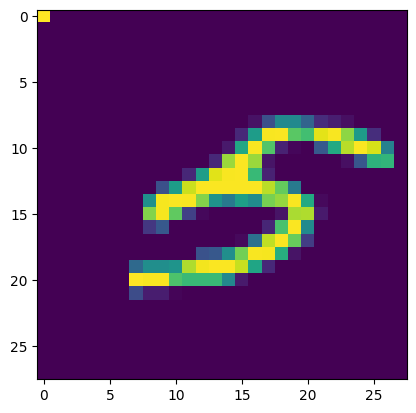

Real: 5
Predicted: 3
Rank of the correct answer: 2
Estimated outputs: [ 0.03587853  0.20975242  0.02347294  0.28036487  0.21085943  0.2343846
  0.01235671 -0.01619576 -0.0292196  -0.04551866] 

Image no. 187


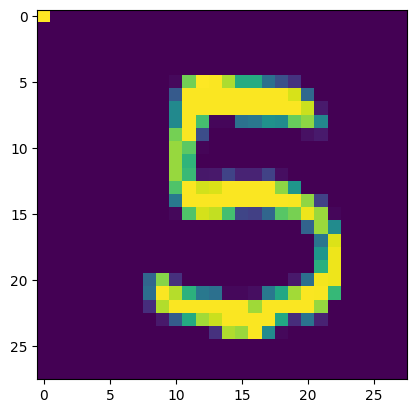

Real: 5
Predicted: 3
Rank of the correct answer: 2
Estimated outputs: [ 0.11151903 -0.04477574  0.11018185  0.38119607 -0.02402081  0.36655041
 -0.10349032 -0.21275917  0.17865371  0.18933491] 

Image no. 195


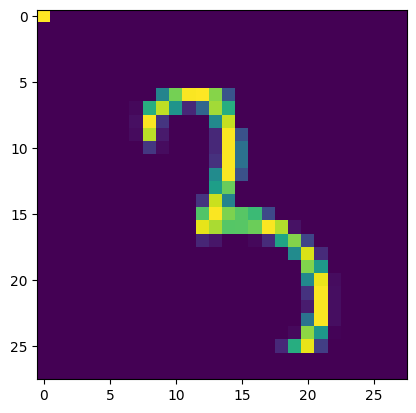

Real: 3
Predicted: 5
Rank of the correct answer: 3
Estimated outputs: [-0.12536491  0.0030235   0.07920567  0.13336749  0.08289944  0.20865922
  0.073615    0.05258198  0.12498437  0.16252456] 



In [26]:
def find_pos(item, lst):
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z]
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(Xt,W)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
        print(f"Image no. {i}")
        display_sample(Xt[i])
        print(f"Real: {np.argmax(yyt[i,:])}")
        print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
        value = yt_estimate[i,np.argmax(yyt[i,:])]
        v_sorted = np.sort(yt_estimate[i,:])
        value_index = find_pos(value,v_sorted)
        print(f"Rank of the correct answer: {10 - value_index[0]}")
        print(f"Estimated outputs: {yt_estimate[i,:]} \n")

<font color="green">
Atividade (e) <br>
Informe o que faz a célula executável acima e analise os resultados obtidos. <br>
</font>

Resposta: 

In [27]:
print("view and comparison between arrays of correct and wrong predictions")
print("-------------------------------------------------------------------")
print("\n-> prediction error:\n")
print("predicted array:", f"\n{yt_estimate[11]}", f" greatest value (index) is: {np.argmax(yt_estimate[11])}")
print("\none-hot-encoded array:", f"\n{yyt[11,:]}", f" '1' index is: {np.argmax(yyt[11])}")
print("\npredicted class: ", np.argmax(yyt[11]))
print("real class: ", np.argmax(yt_estimate[11,:]))
print("\n---------------- : ---------------- : ----------------")
print("\n-> correctly predicted:\n")
print("predicted array:", f"\n{yt_estimate[12]}", f" greatest value (index) is: {np.argmax(yt_estimate[12])}")
print("\none-hot-encoded array:", f"\n{yyt[12,:]}",  f" '1' index is: {np.argmax(yyt[12])}")
print("\npredicted class: ", np.argmax(yyt[12]))
print("real class: ", np.argmax(yt_estimate[12,:]))

view and comparison between arrays of correct and wrong predictions
-------------------------------------------------------------------

-> prediction error:

predicted array: 
[ 0.23368567  0.16012381  0.14317249  0.06792351  0.25748511 -0.16884205
  0.10868754 -0.07912503  0.16923597  0.04993438]  greatest value (index) is: 4

one-hot-encoded array: 
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]  '1' index is: 6

predicted class:  6
real class:  4

---------------- : ---------------- : ----------------

-> correctly predicted:

predicted array: 
[ 0.04522899 -0.00989187  0.01628874 -0.02760958  0.22943109  0.0039076
  0.00704992  0.18965702  0.00830534  0.52981848]  greatest value (index) is: 9

one-hot-encoded array: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  '1' index is: 9

predicted class:  9
real class:  9


<br>
A célula tem como função mostrar erros de predição que ocorreram entre os 200 primeiros dados. Como indicado na célula acima, o classificador determina um array de valores para cada uma das 10 classes (array com 10 posições), sendo o maior valor aquele que determinará qual classe será atribuida ao datapoint em questão. Em seguida, compara-se a posição do maior valor do array de predições com a posição do '1' no array one-hot-encoded de respostas. Se as posições correspondem, a previsão está correta. Do contrário, previsão equivocada (justamente os casos apresentados). Ademais, calcula-se quão errada foi a previsão ao ranquear os valores preditos e determinar em que posição (ordem decrescente) está o valor que deveria ser o maior e, portanto, indicar a classe correta.  

#**Now, let us deal with Part 2: High-level commands.**

In [28]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix

c_values = [pow(2,d) for d in range(-10, 19, 2)] # Range goes up to 19 to ensure search up to 2^18
model = RidgeClassifierCV(alphas=c_values)
model.fit(Xa,y) # The model creates automatically the bias input
print(f"Performance on the test data: {model.score(Xta,yt)} \n")
cf1 = confusion_matrix(model.predict(Xta),yt)
confusion_matrix_df = pd.DataFrame(cf1)
confusion_matrix_df

Performance on the test data: 0.8617 



,0,1,2,3,4,5,6,7,8,9
0,944,0,18,4,0,24,17,5,14,16
1,0,1106,55,17,21,18,10,44,47,11
2,2,2,817,20,6,4,10,15,11,2
3,2,2,25,888,0,75,0,6,31,17
4,2,3,15,5,887,24,22,25,25,79
5,8,1,0,15,3,653,18,0,40,0
6,12,5,38,9,9,24,875,1,17,1
7,2,1,18,20,1,15,0,886,12,76
8,7,15,40,21,9,39,6,0,758,4
9,1,0,6,11,46,16,0,46,19,803


In [29]:
cf2 = confusion_matrix(model.predict(Xta),yt, normalize='true')
confusion_matrix_df = pd.DataFrame(cf2)
confusion_matrix_df

,0,1,2,3,4,5,6,7,8,9
0,0.905950,0.000000,0.017274,0.003839,0.000000,0.023033,0.016315,0.004798,0.013436,0.015355
1,0.000000,0.832205,0.041384,0.012792,0.015801,0.013544,0.007524,0.033108,0.035365,0.008277
2,0.002250,0.002250,0.919010,0.022497,0.006749,0.004499,0.011249,0.016873,0.012373,0.002250
3,0.001912,0.001912,0.023901,0.848948,0.000000,0.071702,0.000000,0.005736,0.029637,0.016252
4,0.001840,0.002760,0.013799,0.004600,0.816007,0.022079,0.020239,0.022999,0.022999,0.072677
5,0.010840,0.001355,0.000000,0.020325,0.004065,0.884824,0.024390,0.000000,0.054201,0.000000
6,0.012109,0.005045,0.038345,0.009082,0.009082,0.024218,0.882947,0.001009,0.017154,0.001009
7,0.001940,0.000970,0.017459,0.019399,0.000970,0.014549,0.000000,0.859360,0.011639,0.073715
8,0.007786,0.016685,0.044494,0.023359,0.010011,0.043382,0.006674,0.000000,0.843159,0.004449
9,0.001055,0.000000,0.006329,0.011603,0.048523,0.016878,0.000000,0.048523,0.020042,0.847046


In [30]:
print(c_values)
print(f'alpha_: {model.alpha_}')

[0.0009765625, 0.00390625, 0.015625, 0.0625, 0.25, 1, 4, 16, 64, 256, 1024, 4096, 16384, 65536, 262144]
alpha_: 64.0


##**Visualization tools for unveiling the classification strategy**

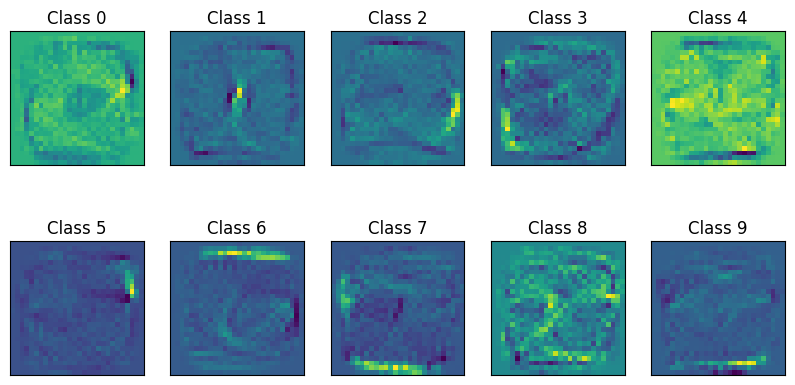

In [31]:
# Only for the MNIST dataset
weights = model.coef_.copy()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = weights[i,:].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap='viridis')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

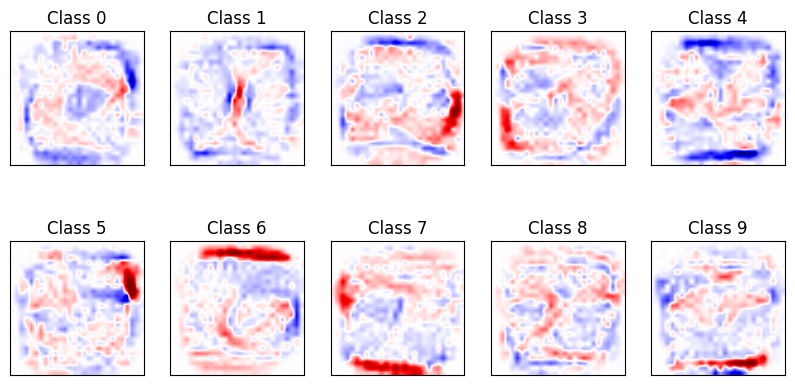

In [32]:
# Only for the MNIST dataset
weights = model.coef_.copy()
scale = np.abs(weights).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = weights[i,:].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

<font color="green">
Atividade (f) <br>
Os resultados da Parte 1 e da Parte 2 são bem similares. Mas as duas partes envolvem estratégias de regularização bem distintas. Qual é a diferença entre a estratégia de regularização da Parte 1 e a estratégia de regularização da Parte 2? <br>
</font>

Resposta: <br><br>
O melhor valor para o hiperparâmetro (c) na Parte 1 é definido através de uma busca em um grid de valores previamente definidos (de 2⁻¹⁰ até 2¹⁸) utilizando o dataset dividido em train-validation-test sets. É uma estratégia simples e eficaz, entretanto tem suas limitações como: <br>
- datasets pequenos não são adequados, pois reduzem a quantidade de dados que poderiam ser utilizados no treinamento ao dividir o conjunto de dados em 3 partes;
- fica-se sujeito a algum eventual viés que a própria divisão dos dados possa causar - treinar, validar e testar com uma parte específica do dataset pode gerar resultados diferentes quando comparados com o mesmo processo executado com divisões distintas do mesmo dataset. 

Assim, na Parte 2, utiliza-se a estratégia de Cross-Validation para definir o melhor hiperparâmetro que atuará na regularização do modelo. Cross-Validation é uma estratégia na qual, após reservar uma parte dos dados para o conjunto de teste, divide-se os demais dados em diversos conjuntos. Em seguida, o modelo é treinado e validado diversas vezes permutando esses conjuntos entre dados de treino e dados de validação. Ao final desse looping, reporta-se o melhor valor obtido para o hiperparâmetro, o qual será utilizado para avaliar a performance do modelo junto aos dados de teste previamente reservados. <br> 
A estratégia de Cross-Validation supre exatamente as deficiências da primeira estratégia, pois permite treinar o modelo com uma maior quantidade de dados e evita que o modelo tenha performances distintas dadas diferentes partições dos dados.

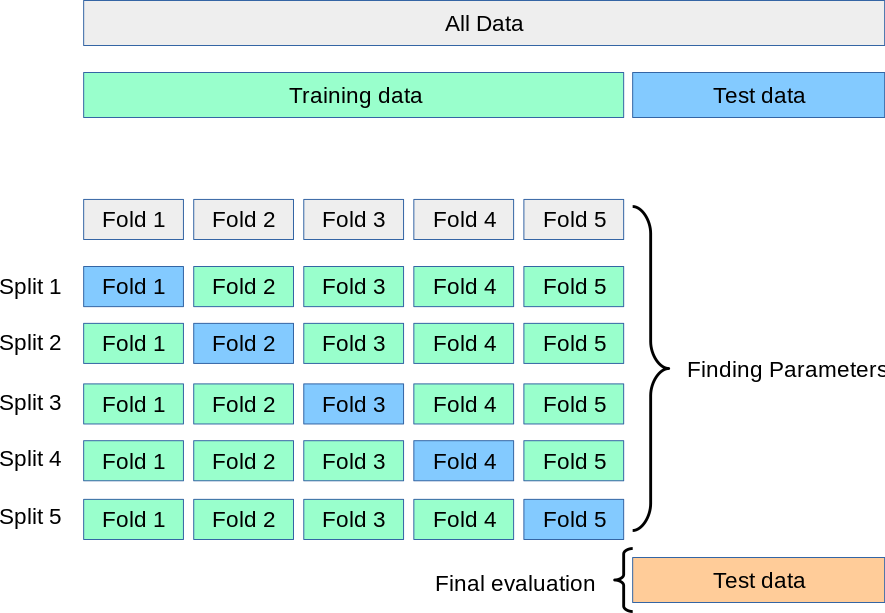

*fonte: https://scikit-learn.org/stable/_images/grid_search_cross_validation.png*

## **Now, let us do the same of Part 2 for the CIFAR-10 dataset.**

In [109]:
from keras.datasets import cifar10

(Xp, y), (Xtp, yt) = cifar10.load_data()
Xa = Xp.reshape(Xp.shape[0], 3072)
Xta = Xtp.reshape(Xtp.shape[0], 3072)
y = y.ravel()
yt = yt.ravel()
X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

Shape of X:  (50000, 3072)
Shape of y:  (50000,)
Shape of Xt:  (10000, 3072)
Shape of yt:  (10000,)


In [34]:
# Dataset balancing analysis
from tensorflow.keras.utils import to_categorical
import plotly.express as px

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)
fig1 = px.bar(x=range(10),y=sum_along_columns1, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the training dataset</b>")
fig1.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig1.show()
fig2 = px.bar(x=range(10),y=sum_along_columns2, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the test dataset</b>")
fig2.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig2.show()

[5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


In [35]:
c_values = [pow(2,d) for d in range(-10, 19, 2)] # Range goes up to 19 to ensure search up to 2^18
model1 = RidgeClassifierCV(alphas=c_values)
model1.fit(X,y)
print(f"Performance on the test data: {model1.score(Xt,yt)} \n")
cf3 = confusion_matrix(model1.predict(Xt),yt)
confusion_matrix_df = pd.DataFrame(cf3)
confusion_matrix_df

Performance on the test data: 0.4078 



,0,1,2,3,4,5,6,7,8,9
0,509,58,132,64,72,53,27,65,145,64
1,52,522,57,84,44,75,62,70,77,207
2,24,6,193,67,91,77,50,43,4,10
3,18,23,69,187,53,112,66,44,16,14
4,19,14,110,38,266,58,75,63,2,8
5,23,25,77,200,76,337,63,71,38,21
6,30,39,189,162,204,103,549,43,19,48
7,50,53,75,48,124,71,44,455,16,47
8,192,87,58,60,31,74,24,41,573,94
9,83,173,40,90,39,40,40,105,110,487


In [36]:
cf4 = confusion_matrix(model1.predict(Xt),yt, normalize='true')
confusion_matrix_df = pd.DataFrame(cf4)
confusion_matrix_df

,0,1,2,3,4,5,6,7,8,9
0,0.428091,0.048780,0.111018,0.053827,0.060555,0.044575,0.022708,0.054668,0.121951,0.053827
1,0.041600,0.417600,0.045600,0.067200,0.035200,0.060000,0.049600,0.056000,0.061600,0.165600
2,0.042478,0.010619,0.341593,0.118584,0.161062,0.136283,0.088496,0.076106,0.007080,0.017699
3,0.029900,0.038206,0.114618,0.310631,0.088040,0.186047,0.109635,0.073090,0.026578,0.023256
4,0.029096,0.021440,0.168453,0.058193,0.407351,0.088821,0.114855,0.096478,0.003063,0.012251
5,0.024705,0.026853,0.082707,0.214823,0.081633,0.361976,0.067669,0.076262,0.040816,0.022556
6,0.021645,0.028139,0.136364,0.116883,0.147186,0.074315,0.396104,0.031025,0.013709,0.034632
7,0.050865,0.053917,0.076297,0.048830,0.126144,0.072228,0.044761,0.462869,0.016277,0.047813
8,0.155592,0.070502,0.047002,0.048622,0.025122,0.059968,0.019449,0.033225,0.464344,0.076175
9,0.068766,0.143331,0.033140,0.074565,0.032312,0.033140,0.033140,0.086993,0.091135,0.403480


In [37]:
print(c_values)
print(f'alpha_: {model1.alpha_}')

[0.0009765625, 0.00390625, 0.015625, 0.0625, 0.25, 1, 4, 16, 64, 256, 1024, 4096, 16384, 65536, 262144]
alpha_: 1024.0


##**Visualization tools for unveiling the classification strategy**

(10, 3072)


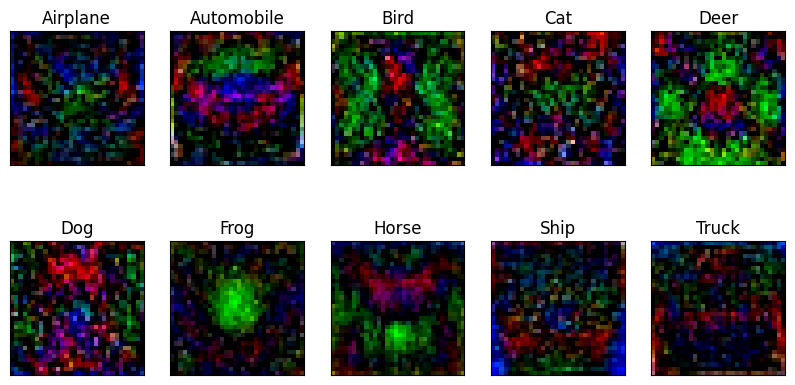

In [38]:
from matplotlib.pyplot import figure

figure(figsize=(10, 5))
weights = model1.coef_.copy()
print(weights.shape)
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight1 = weights[i,:].reshape([32,32,3])
    weight1 *= 1.0/weight1.max()
    weight2 = np.clip(weight1, 0, 1)
    plt.title(classes[i])
    plt.imshow(weight2)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

<font color="green">
Atividade (g) <br>
Observando as figuras logo acima, informe qual é a estratégia adotada pelo classificador RidgeClassifierCV para a base CIFAR-10. <br>
</font>

Resposta:

In [113]:
# Visualizing a random data point. 
import plotly.express as px

ind = 8888
print('Data point: ', ind, '\nLabel: ', classes[y[ind]])
fig = px.imshow(Xp[ind], binary_string=True, width=200, height=200)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(margin=dict(l=1, r=1, t=1, b=1))
fig.show()

print("'artifacts': we want to classify this image as a bird, but there is something like a tree branch as extra information")

Data point:  8888 
Label:  Bird


'artifacts': we want to classify this image as a bird, but there is something like a tree branch as extra information


In [114]:
Xp[8888][:32].shape  # extra dimension for RGB values 

(32, 32, 3)

O classificador busca identificar regiões peculiares de cada classe. <br>Diferentemente da Parte A, com o dataset MNIST, os mapas gerados pelo classificador são inteligíveis - podemos identificar, mesmo com um pouco de distorção, um traçado compatível com os números correspondentes a cada classe. Já na Parte B, com o dataset CIFAR-10, é impossível visualizar e associar qualquer um dos mapas com a imagem de um exemplar da classe. Por exemplo, para a primeira classe, é impossível associar o borrão de pixels coloridos apresentados com um avião (classe airplane) seja ele qual for. <br>Portanto, o classificador, para o dataset MNIST, busca identificar semelhanças entre os elementos da classe, juntamente com regiões de pixels que sejam únicas e diferenciem as classes entre si. Todavia, para o dataset CIFAR-10, em função da maior complexidade das imagens, as quais possuem outros elementos além do objeto de interesse a ser classificado e são coloridas (possuem uma terceira dimensão correspondente aos valores RGB de cada pixel além das dimensões de altura e largura), a estratégia adotada pelo classificador é buscar regiões que sejam exclusivas de cada classe, resultando em uma espécie de classificação por diferenças e não necessariamente por semelhanças. 

<font color="green">
Atividade (h) <br>
Comparando os dois conjuntos de dados (MNIST e CIFAR-10), o que pode sustentar a grande perda de desempenho verificada para o caso da base CIFAR-10? <br>
</font>

Resposta:<br><br>
A resposta anterior versa sobre duas situações que agregam bastante complexidade ao problema de classificação e podem justificar a grande perda de desempenho verificada no dataset CIFAR-10:<br>
* imagens coloridas, diferentemente do dataset MNIST, trazem outra dimensão à matriz dos pixels, a qual é necessária para representar os valores RGB (Red, Green, Blue);<br>

* imagens mais complexas, pois possuem outras "estruturas" como galhos, mar, céu, objetos de uma mesma classe posicionados de diferentes formas, etc.<br>

Certamente, esse aumento de complexidade na matriz de pixels e grande variabilidade entre as imagens de uma mesma classe agregam grande dificuldade ao processo de classificação.